In [1]:
import captum.attr as ca
import os
import numpy as np
from tqdm import tqdm
import nibabel as nib
import pandas as pd
import torch
import matplotlib.pyplot as plt
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule, IdentityRule
from captum.attr import visualization as viz

from model.sfcn_reg import RegressionSFCN
from model.utils.etc import WeightRepository
from model.utils.nn_utils import Conv3DSame

In [2]:
WEIGHT_PATH = '../.pyment/pyment/data/sfcn-regbrain-age-2022.h5'
MIN_AGE = 3
MAX_AGE = 95

model = RegressionSFCN(prediction_range=None)
torch_weights = WeightRepository.convert_to_torch(WEIGHT_PATH, model.state_dict())
model.load_state_dict(torch_weights)

<All keys matched successfully>

In [3]:
model

RegressionSFCN(
  (fn1): Sequential(
    (sfcn-reg_block1_conv): Conv3DSame(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (sfcn-reg_block1_norm): BatchNorm3d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (sfcn-reg_block1_relu): ReLU()
    (sfcn-reg_block1_pool): MaxPool3dIndices(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (sfcn-reg_block2_conv): Conv3DSame(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (sfcn-reg_block2_norm): BatchNorm3d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (sfcn-reg_block2_relu): ReLU()
    (sfcn-reg_block2_pool): MaxPool3dIndices(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (sfcn-reg_block3_conv): Conv3DSame(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (sfcn-reg_block3_norm): BatchNorm3d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (sfcn-reg_block3_relu):

In [4]:
LABELS_FILE = "../test_data/IXI/IXI.xls"
IMAGE_FOLDER = "../test_data/IXI"

labels = pd.read_excel(LABELS_FILE)
labels.head()

,IXI_ID,"SEX_ID (1=m, 2=f)",HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE
0,1,1,170,80,2,3,5,2,1968-02-22,0,NaT,NaN
1,2,2,164,58,1,4,1,5,1970-01-30,1,2005-11-18,35.800137
2,12,1,175,70,1,2,1,5,1966-08-20,1,2005-06-01,38.781656
3,13,1,182,70,1,2,1,5,1958-09-15,1,2005-06-01,46.710472
4,14,2,163,65,1,4,1,5,1971-03-15,1,2005-06-09,34.236824


In [11]:
for subject in tqdm(os.listdir(IMAGE_FOLDER)):#
    if "IXI" in subject and os.path.isdir(os.path.join(IMAGE_FOLDER, subject)):
        path = os.path.join(IMAGE_FOLDER, subject, 'anat', 'cropped_T1w.nii.gz')
        subjectid = int(subject[7:])
        if not os.path.isfile(path):
            print(f'Skipping {subject}: Missing cropped.nii.gz')
            continue
        elif subjectid not in labels['IXI_ID'].values:
            print(f'Skipping {subject}: Missing labels')
            continue

        age = labels.loc[labels['IXI_ID'] == subjectid, 'AGE'].values[0]
        
        img = nib.load(path)
        img : np.ndarray = img.get_fdata()
        img = np.expand_dims(img, 0)

        break

  0%|          | 0/87 [00:00<?, ?it/s]


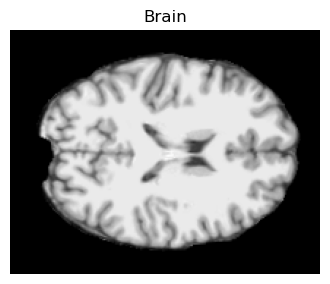

In [12]:
plt.figure(figsize=(4, 4))
plt.imshow(img[0,:,:,95], cmap="gray")
plt.title("Brain")
plt.axis("off")
plt.show()

In [13]:
img.shape

(1, 167, 212, 160)

In [23]:
from utils.transforms import Resize3D

In [29]:
model.eval()
torch_img = torch.from_numpy(img).float().unsqueeze(0)
print(torch_img.shape)
resize_torch_img = Resize3D([168, 192, 160], "trilinear")(torch_img)
resize_torch_img.shape

torch.Size([1, 1, 167, 212, 160])


torch.Size([1, 1, 168, 192, 160])

In [33]:
output = model(resize_torch_img)
output

tensor([[36.0465]], grad_fn=<AddmmBackward0>)

In [34]:
def train_single_sample(model, sample_input, sample_target, learning_rate=0.01):
    # Define the loss function and optimizer
    criterion = torch.nn.MSELoss()  # Example loss for regression
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Convert inputs and targets to tensors
    input_tensor = torch.tensor(sample_input, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
    target_tensor = torch.tensor(sample_target, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    output = model(input_tensor)

    # Calculate loss
    loss = criterion(output, target_tensor)

    # Backward pass (compute gradients)
    loss.backward()

    # Update weights using SGD
    optimizer.step()

    return loss.item()


In [36]:
train_single_sample(model, resize_torch_img.squeeze(0), 10)

/var/folders/1f/nqsl_8_x3gbg38z_zv6_nwfc0000gn/T/ipykernel_28313/1373764456.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(sample_input, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
/Users/kingpowa/miniconda3/envs/ai-env/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


678.4202270507812

In [8]:
from lrp.utils import get_layer_keys_before_lrp, expand_model
from lrp.rules import AllOnesRule

get_layer_keys_before_lrp(model)

['fn1.sfcn-reg_block1_conv',
 'fn1.sfcn-reg_block1_pool',
 'fn1.sfcn-reg_block2_conv',
 'fn1.sfcn-reg_block2_pool',
 'fn1.sfcn-reg_block3_conv',
 'fn1.sfcn-reg_block3_pool',
 'fn1.sfcn-reg_block4_conv',
 'fn1.sfcn-reg_block4_pool',
 'fn1.sfcn-reg_block5_conv',
 'fn1.sfcn-reg_block5_pool',
 'fn1.sfcn-reg_top_conv',
 'fn1.sfcn-reg_top_pool',
 'linear.sfcn-reg_predictions']

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

from captum.attr._utils.lrp_rules import PropagationRule
from model.utils.nn_utils import MaxPool3dIndices

class WinnerTakesAll(PropagationRule):
    """
    Sets all weights and inputs to ones, similar to the "flat" mode in the TF implementation.
    """
    def __init__(self, name):
        super().__init__()
        self.name = name

    def _manipulate_weights(self, module: MaxPool3dIndices, inputs, outputs):
        pass
        
    def _create_backward_hook_input(self, inputs):
        def _backward_hook_input(grad):
            print("Inputs", self.name, grad[grad != 0])
            relevance = grad * inputs
            device = grad.device
            if self._has_single_input:
                self.relevance_input[device] = relevance.data
            else:
                self.relevance_input[device].append(relevance.data)

            # replace_out is needed since two hooks are set on the same tensor
            # The output of this hook is needed in backward_hook_activation
            grad.replace_out = relevance
            return relevance

        return _backward_hook_input

    def _create_backward_hook_output(self, outputs):
        def _backward_hook_output(grad):
            print("Outputs", self.name, grad[grad != 0])
            self.relevance_output[grad.device] = grad.data
            return grad

        return _backward_hook_output

In [56]:
rules = {'fn1.sfcn-reg_block1_conv': AllOnesRule(),
 'fn1.sfcn-reg_block2_conv': AllOnesRule(),
 'fn1.sfcn-reg_block3_conv': Alpha1_Beta0_Rule(),
 'fn1.sfcn-reg_block4_conv': Alpha1_Beta0_Rule(),
 'fn1.sfcn-reg_block5_conv': Alpha1_Beta0_Rule(),
 'fn1.sfcn-reg_top_conv': Alpha1_Beta0_Rule(),
 'linear.sfcn-reg_predictions':EpsilonRule(0.25),
 'fn1.sfcn-reg_block1_pool': WinnerTakesAll(1),
 'fn1.sfcn-reg_block2_pool': WinnerTakesAll(2),
 'fn1.sfcn-reg_block3_pool': WinnerTakesAll(3),
 'fn1.sfcn-reg_block4_pool': WinnerTakesAll(4),
 'fn1.sfcn-reg_block5_pool': WinnerTakesAll(5),
 'fn1.sfcn-reg_top_conv': EpsilonRule(1e-9),
 'fn1.sfcn-reg_top_pool': EpsilonRule(1e-9)}

In [57]:
from lrp.applier import LRPApplier

lrpappl = LRPApplier(model, rules)

In [58]:
attributions_lrp = lrpappl.attribute(torch.from_numpy(img).float().unsqueeze(0).requires_grad_())

Outputs EpsilonRule tensor([0.0403])
Inputs EpsilonRule tensor([0.0536, 0.0550, 0.0545, 0.0556, 0.0599, 0.0606, 0.0540, 0.0523, 0.0583,
        0.0605, 0.0593, 0.0517, 0.0583, 0.0593, 0.0577, 0.0547, 0.0596, 0.0559,
        0.0578, 0.0551, 0.0597, 0.0587, 0.0575, 0.0591, 0.0587, 0.0583, 0.0558,
        0.0589, 0.0582, 0.0596, 0.0591, 0.0563, 0.0573, 0.0580, 0.0558, 0.0555,
        0.0571, 0.0553, 0.0601, 0.0586, 0.0587, 0.0569, 0.0554, 0.0600, 0.0550,
        0.0527, 0.0589, 0.0565, 0.0597, 0.0538, 0.0578, 0.0599, 0.0526, 0.0560,
        0.0602, 0.0600, 0.0617, 0.0615, 0.0607, 0.0568, 0.0588, 0.0570, 0.0549,
        0.0573])
Outputs EpsilonRule tensor([0.0536, 0.0550, 0.0545, 0.0556, 0.0599, 0.0606, 0.0540, 0.0523, 0.0583,
        0.0605, 0.0593, 0.0517, 0.0583, 0.0593, 0.0577, 0.0547, 0.0596, 0.0559,
        0.0578, 0.0551, 0.0597, 0.0587, 0.0575, 0.0591, 0.0587, 0.0583, 0.0558,
        0.0589, 0.0582, 0.0596, 0.0591, 0.0563, 0.0573, 0.0580, 0.0558, 0.0555,
        0.0571, 0.0553, 0.0

In [59]:
attributions_lrp.shape, img.shape

(torch.Size([1, 1, 167, 212, 160]), (1, 167, 212, 160))

In [62]:
attributions_lrp[0,0][img[0] == 0] = 0

In [63]:
attributions_lrp = attributions_lrp / torch.amax(torch.abs(attributions_lrp))

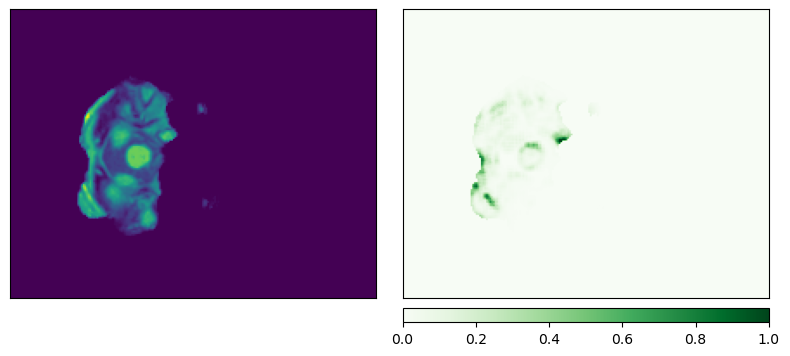

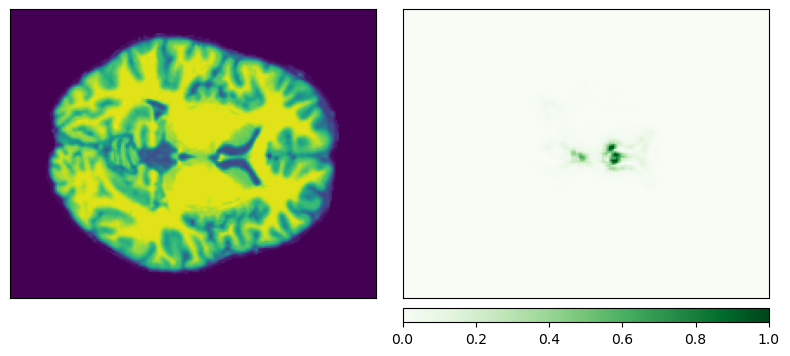

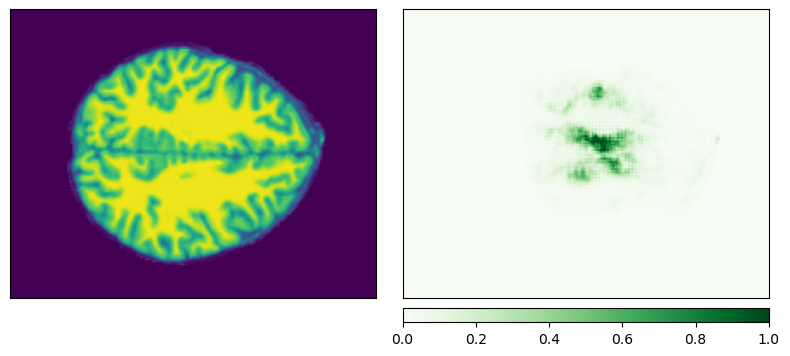

In [64]:
_ = viz.visualize_image_attr_multiple(attributions_lrp.squeeze().cpu().detach().numpy()[:,:,[30]],
                                      img.squeeze()[:,:,[30]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

_ = viz.visualize_image_attr_multiple(attributions_lrp.squeeze().cpu().detach().numpy()[:,:,[80]],
                                      img.squeeze()[:,:,[80]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

_ = viz.visualize_image_attr_multiple(attributions_lrp.squeeze().cpu().detach().numpy()[:,:,[110]],
                                      img.squeeze()[:,:,[110]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

In [48]:
from zennit.rules import Epsilon, Flat, AlphaBeta, BasicHook, NoMod
from copy import deepcopy

new_model = deepcopy(model)

In [49]:
from zennit.canonizers import SequentialMergeBatchNorm

# create the canonizer
canonizer = SequentialMergeBatchNorm()

# apply the canonizer to the model, which creates multiple canonizer
# instances, one per applicable case
instances = canonizer.apply(new_model)

In [50]:
from zennit.core import Hook, BasicHook, Stabilizer, expand, ParamMod

class WinnerTakesAllTest(BasicHook):

    def __init__(self, epsilon=1e-9, zero_params=None, name = ""):
        super().__init__(
            input_modifiers=[lambda input: input],
            param_modifiers=[NoMod(zero_params=zero_params)],
            output_modifiers=[lambda output: output],
            gradient_mapper=(lambda out_grad, outputs: out_grad),
            reducer=(lambda inputs, gradients: inputs[0] * gradients[0]),
        )
        self.name = name

    def backward(self, module, grad_input, grad_output):
        original_input = self.stored_tensors['input'][0].clone()
        inputs = []
        outputs = []
        for in_mod, param_mod, out_mod in zip(self.input_modifiers, self.param_modifiers, self.output_modifiers):
            input = in_mod(original_input).requires_grad_()
            with ParamMod.ensure(param_mod)(module) as modified, torch.autograd.enable_grad():
                output = modified.forward(input)
                output = out_mod(output)
            inputs.append(input)
            outputs.append(output)
        grad_outputs = self.gradient_mapper(grad_output[0], outputs)
        print("Outputs", self.name, grad_output[0][grad_output[0] != 0])
        gradients = torch.autograd.grad(
            outputs,
            inputs,
            grad_outputs=grad_outputs,
            create_graph=grad_output[0].requires_grad
        )
        print("Inputs", self.name, gradients[0][gradients[0] != 0])
        relevance = self.reducer(inputs, gradients)
        return tuple(relevance if original.shape == relevance.shape else None for original in grad_input)

In [51]:
rules : dict[str, BasicHook] = {'fn1.sfcn-reg_block1_conv': Flat(1e-9),
 'fn1.sfcn-reg_block2_conv': Flat(1e-9),
 'fn1.sfcn-reg_block3_conv': AlphaBeta(alpha=1, beta=0 , stabilizer=1e-9),
 'fn1.sfcn-reg_block4_conv': AlphaBeta(alpha=1, beta=0 , stabilizer=1e-9),
 'fn1.sfcn-reg_block5_conv': AlphaBeta(alpha=1, beta=0 , stabilizer=1e-9),
 'fn1.sfcn-reg_top_conv': AlphaBeta(alpha=1, beta=0 , stabilizer=1e-9),
 'linear.sfcn-reg_predictions': Epsilon(0.25),
 'fn1.sfcn-reg_block1_pool': WinnerTakesAllTest(),
 'fn1.sfcn-reg_block2_pool': WinnerTakesAllTest(),
 'fn1.sfcn-reg_block3_pool': WinnerTakesAllTest(),
 'fn1.sfcn-reg_block4_pool': WinnerTakesAllTest(),
 'fn1.sfcn-reg_block5_pool': WinnerTakesAllTest(),
 'fn1.sfcn-reg_top_pool': Epsilon(1e-9),
 'fn1.sfcn-reg_top_conv': Epsilon(1e-9)}

In [52]:
handles = []
for key, layer in expand_model(new_model.named_children()):
    if key in rules:
        handles.append(rules[key].register(layer))

In [53]:
ipt = torch.from_numpy(img).float().unsqueeze(0).requires_grad_()
output = new_model(ipt)
output

tensor([[24.5426]], grad_fn=<AddmmBackward0>)

In [54]:
attribution, = torch.autograd.grad(
    output, ipt, grad_outputs=torch.ones_like(output)
)

Outputs Epsilon tensor([0.0403])
Inputs Epsilon tensor([0.0536, 0.0551, 0.0545, 0.0556, 0.0600, 0.0607, 0.0540, 0.0523, 0.0583,
        0.0606, 0.0593, 0.0518, 0.0583, 0.0593, 0.0578, 0.0548, 0.0597, 0.0560,
        0.0578, 0.0551, 0.0597, 0.0587, 0.0576, 0.0591, 0.0588, 0.0584, 0.0559,
        0.0590, 0.0583, 0.0597, 0.0591, 0.0563, 0.0573, 0.0581, 0.0558, 0.0555,
        0.0571, 0.0553, 0.0601, 0.0587, 0.0587, 0.0570, 0.0555, 0.0601, 0.0551,
        0.0527, 0.0590, 0.0566, 0.0598, 0.0538, 0.0579, 0.0600, 0.0526, 0.0561,
        0.0603, 0.0601, 0.0618, 0.0616, 0.0607, 0.0568, 0.0588, 0.0570, 0.0550,
        0.0574])
Outputs Epsilon tensor([0.0536, 0.0551, 0.0545, 0.0556, 0.0600, 0.0607, 0.0540, 0.0523, 0.0583,
        0.0606, 0.0593, 0.0518, 0.0583, 0.0593, 0.0578, 0.0548, 0.0597, 0.0560,
        0.0578, 0.0551, 0.0597, 0.0587, 0.0576, 0.0591, 0.0588, 0.0584, 0.0559,
        0.0590, 0.0583, 0.0597, 0.0591, 0.0563, 0.0573, 0.0581, 0.0558, 0.0555,
        0.0571, 0.0553, 0.0601, 0.0587,

In [60]:
attribution.shape

torch.Size([1, 1, 167, 212, 160])

In [61]:
attribution[0,0][img[0] == 0] = 0

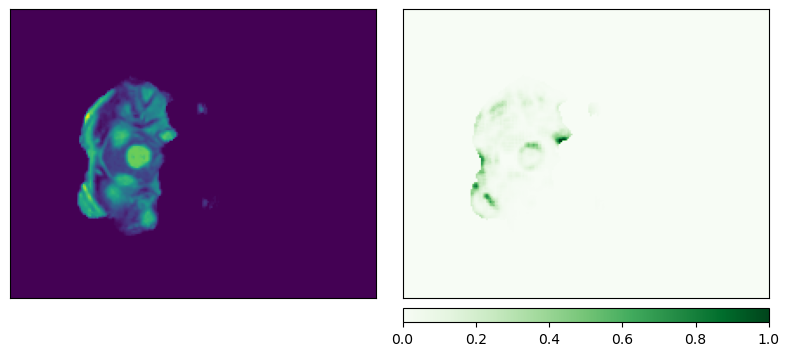

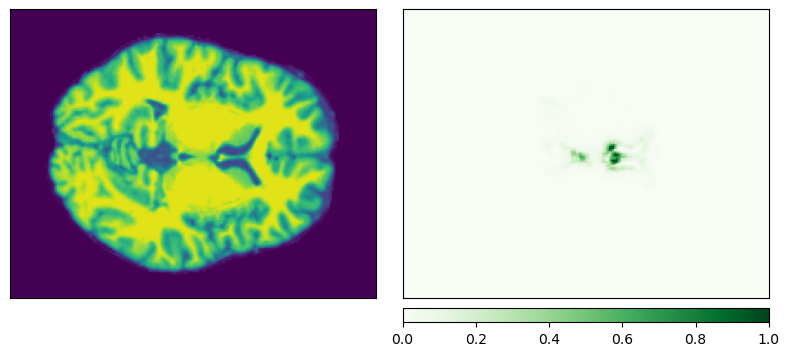

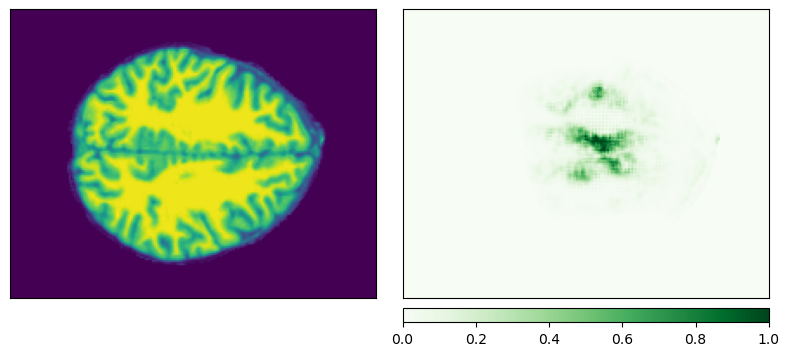

In [65]:
_ = viz.visualize_image_attr_multiple(attribution.squeeze().cpu().detach().numpy()[:,:,[30]],
                                      img.squeeze()[:,:,[30]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

_ = viz.visualize_image_attr_multiple(attribution.squeeze().cpu().detach().numpy()[:,:,[80]],
                                      img.squeeze()[:,:,[80]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)

_ = viz.visualize_image_attr_multiple(attribution.squeeze().cpu().detach().numpy()[:,:,[110]],
                                      img.squeeze()[:,:,[110]],
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2)